In [1]:
import pyro.distributions as dist
import pyro.ops.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16, 8]
plt.style.use('ggplot')

### simulate the position of random movement of coin toss

In [2]:
pos = [np.sum(np.random.choice([-1, 1], size=16)) for _ in range(1000)]

<AxesSubplot:ylabel='Density'>

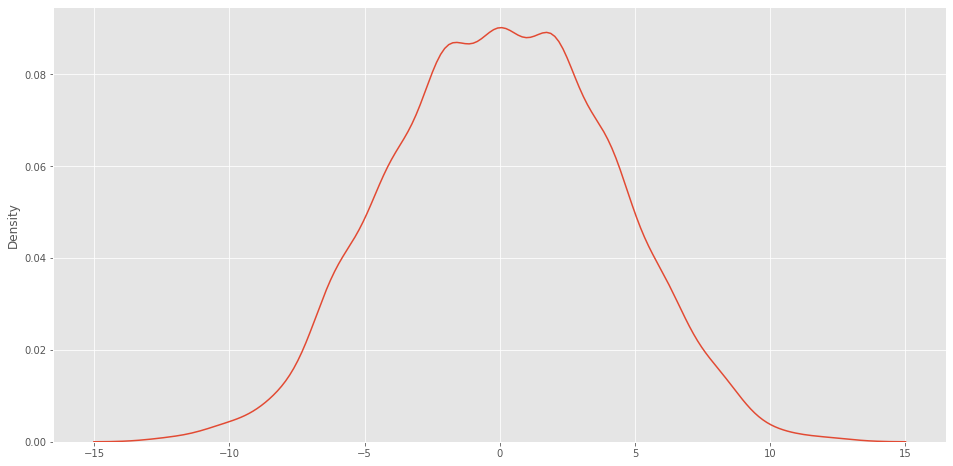

In [3]:
sns.kdeplot(pos)

We can also do this using torch

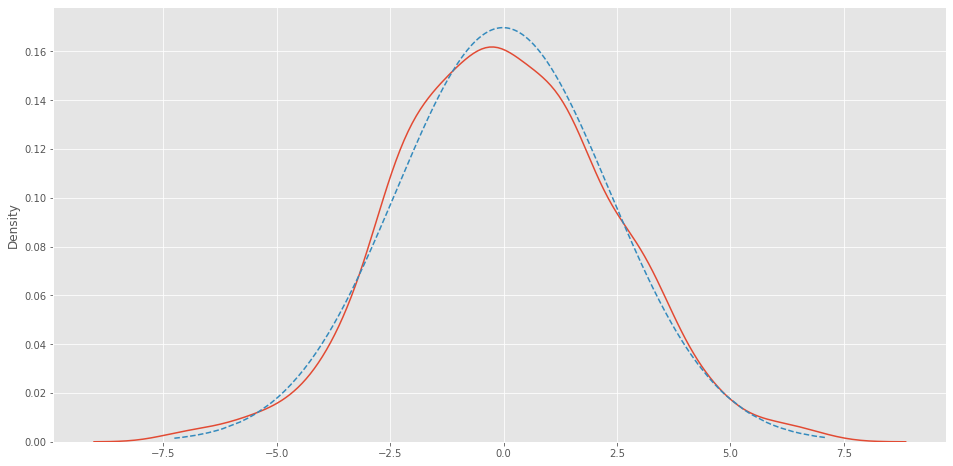

In [4]:
import torch
pos = torch.empty(1000, 16).uniform_(-1, 1).sum(1)
sns.kdeplot(pos)
ax = sns.lineplot(x=pos, y=dist.Normal(pos.mean(), pos.std()).log_prob(pos).exp())
ax.lines[1].set_linestyle('--')

the dist.normal calculates the theoretical density at each x given.

In [5]:
from statsmodels.graphics.gofplots import qqplot

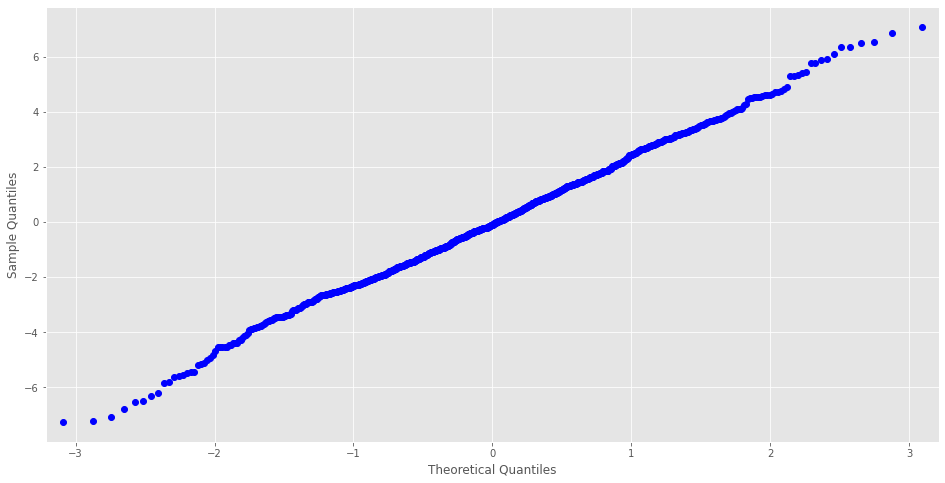

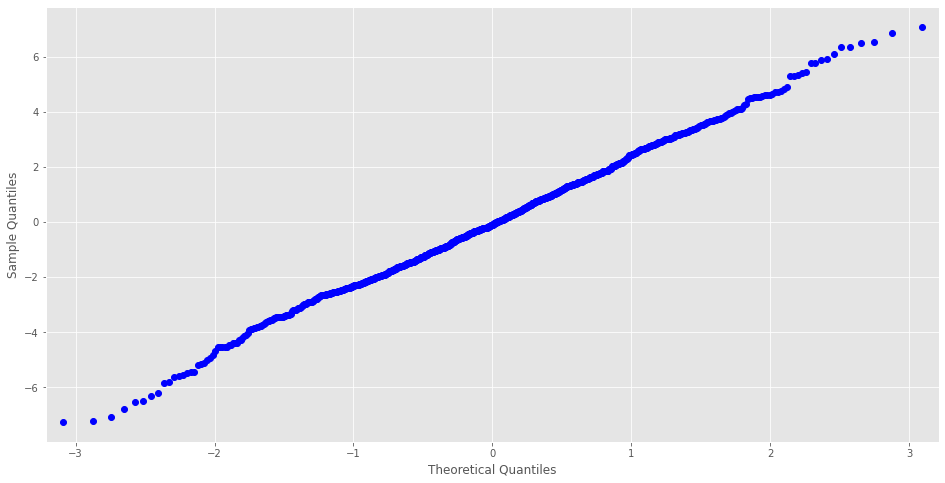

In [6]:
qqplot(np.array(pos))

In [7]:
growth = np.array([np.prod(np.random.uniform(1, 1.1, 12)) for _ in range(1000)])

<AxesSubplot:ylabel='Density'>

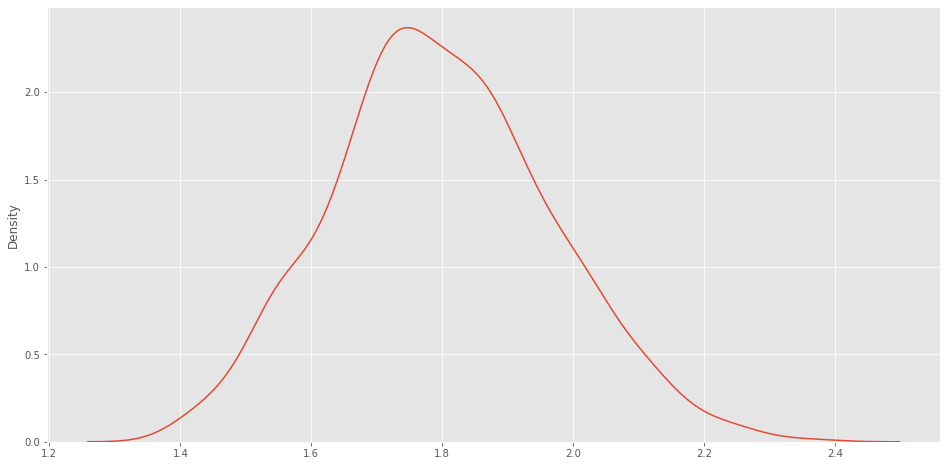

In [8]:
sns.kdeplot(growth)

again the distribution is normal like.

<AxesSubplot:ylabel='Density'>

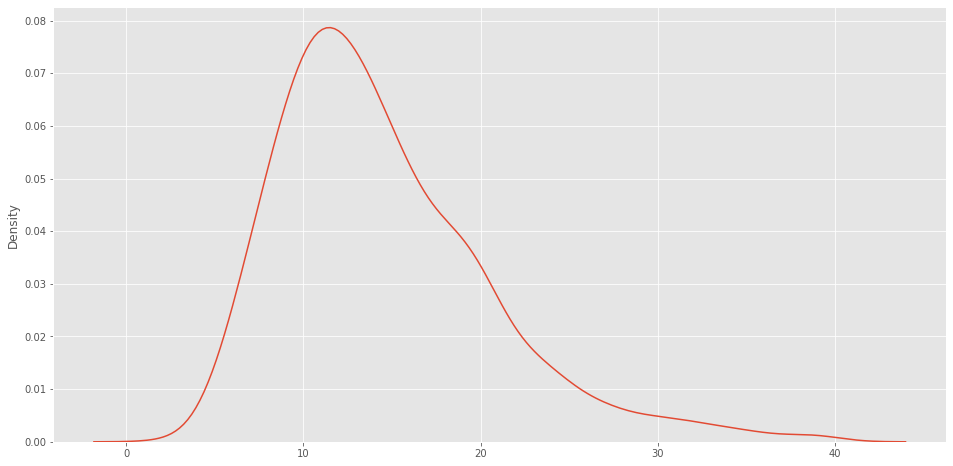

In [9]:
sns.kdeplot(np.array([np.prod(np.random.uniform(1, 1.5, 12)) for _ in range(1000)]))

Although multiple of large growth does not result in a normal distribution, the log does.

<AxesSubplot:ylabel='Density'>

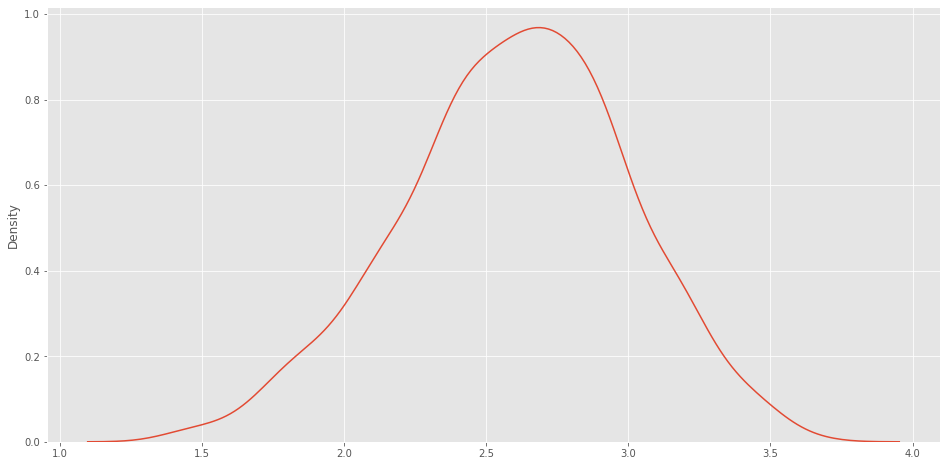

In [10]:
sns.kdeplot(np.array([np.log(np.prod(np.random.uniform(1, 1.5, 12))) for _ in range(1000)]))

Once we took the log, we get the bell shape distribution again. This is because once we take the log, multiplication becomes addition.

The normal distribution shape comes largely from the $\exp(-x^2)$ term in the formula.

<AxesSubplot:>

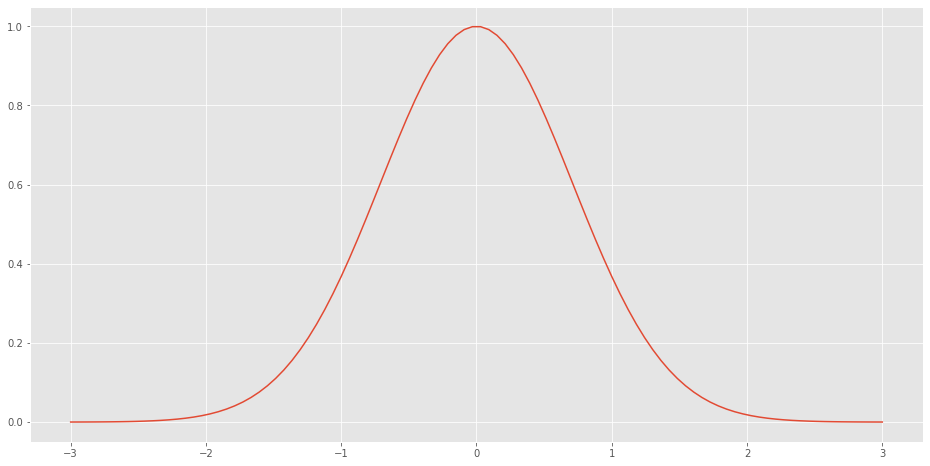

In [11]:
x = np.linspace(-3, 3, 100)
y = np.exp(-x**2)
sns.lineplot(x=x, y=y)

In [12]:
import pyro.distributions as dist

In [13]:
dist.Normal(10, 1)

Normal(loc: 10.0, scale: 1.0)

<AxesSubplot:>

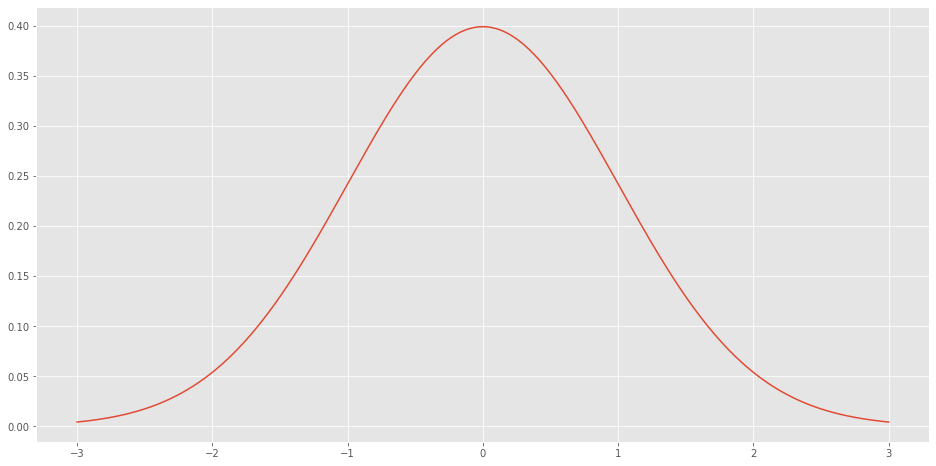

In [14]:
x = torch.linspace(-3, 3, 1000)
y = dist.Normal(0, 1).log_prob(x).exp()
sns.lineplot(x=x, y=y)

In [15]:
import pandas as pd
howell1 = pd.read_csv('data/Howell1.csv', sep=';')
howell1

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062496,21.0,0
542,71.120,8.051258,0.0,1


In [16]:
howell1.describe()

,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
25%,125.095000,22.007717,12.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
75%,157.480000,47.209005,43.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


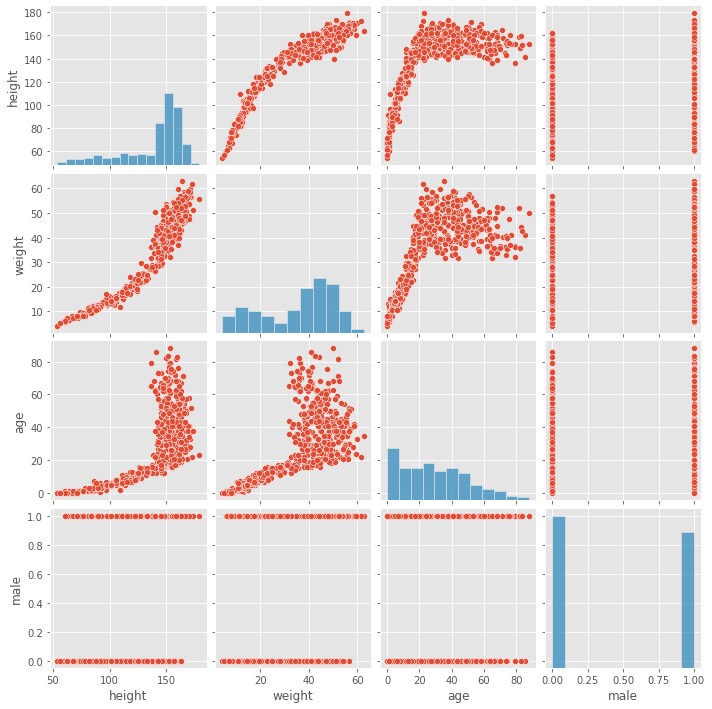

In [17]:
sns.pairplot(howell1)

In [18]:
adults = howell1[howell1['age'] >= 18]

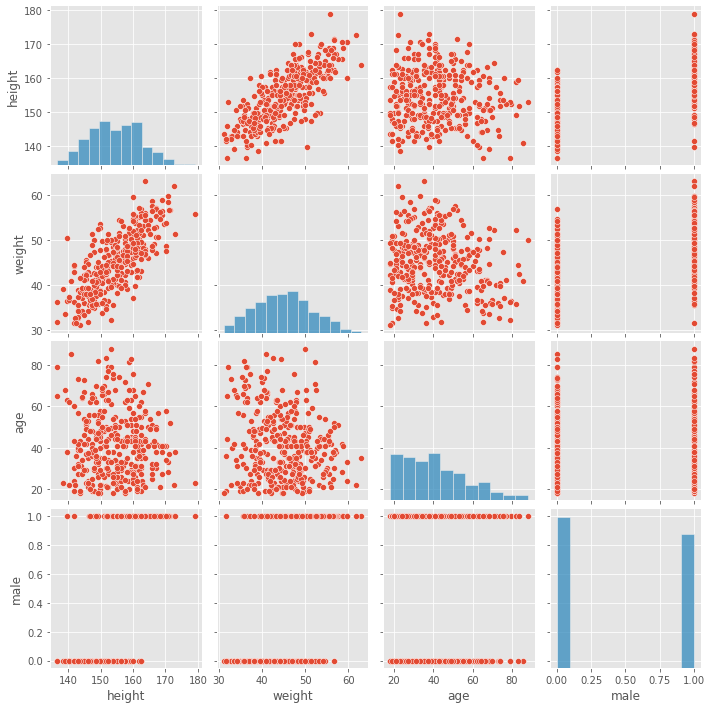

In [19]:
sns.pairplot(adults)

### Estimate the linear model

height ~ weight

In [20]:
adult_data_x = torch.FloatTensor(adults['weight']).reshape(-1, 1)
adult_data_y = torch.FloatTensor(adults['height'])

In [21]:
from src.linear_model import BayesianMCMCLinearModel

In [22]:
adult_model_prior = {'bias': dist.Normal(178, 20),
                    'weights': dist.Normal(0, 10).expand([1]).to_event(1),
                    'sigma': dist.Uniform(0, 50)}
adult_lm = BayesianMCMCLinearModel(
    X=adult_data_x, 
    y=adult_data_y, 
    prior=adult_model_prior, 
    warmup_steps=1000, 
    num_samples=3000
)

In [23]:
adult_lm.fit()

Warmup:   0%|          | 0/4000 [00:00, ?it/s]/home/mk/Git/statistical_rethinking_python/venv/lib/python3.6/site-packages/torch/autograd/__init__.py:204: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  inputs, allow_unused)
Sample: 100%|██████████| 4000/4000 [07:17,  9.15it/s, step size=9.35e-02, acc. prob=0.946]


In [24]:
adult_lm.posterior_summary()

,count,mean,std,min,5%,50%,95%,max
bias,1000.0,114.590454,1.901688,107.560730,111.324334,114.681499,117.555121,119.837479
weights_1,1000.0,0.889745,0.042050,0.766104,0.823042,0.887363,0.961333,1.050234
sigma,1000.0,5.105490,0.191159,4.393786,4.804797,5.100962,5.414582,5.872333


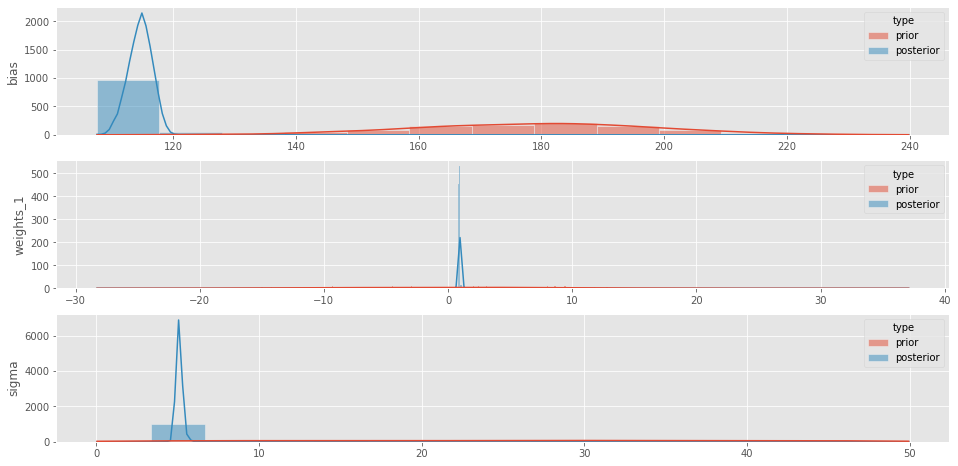

In [25]:
adult_lm.plot_prior_posterior()

In [26]:
adult_lm.mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      bias    114.56      1.92    114.61    111.56    117.81    883.30      1.00
weights[0]      0.89      0.04      0.89      0.82      0.96    868.38      1.00
     sigma      5.10      0.19      5.10      4.79      5.42   1219.78      1.00

Number of divergences: 0


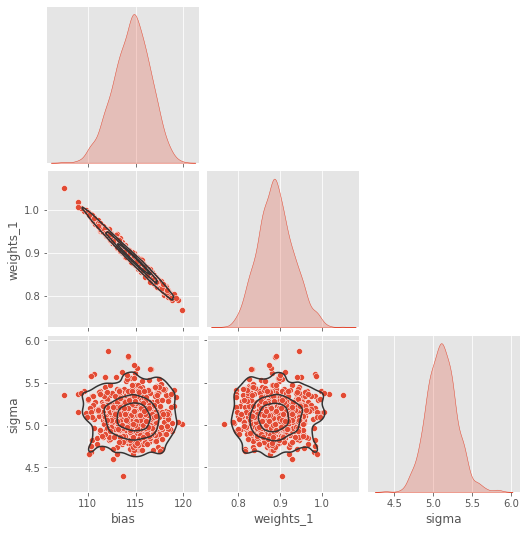

In [27]:
adult_lm.plot_joint_posterior()

Not sure that that is, but probably non convergence.

/home/mk/Git/statistical_rethinking_python/venv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


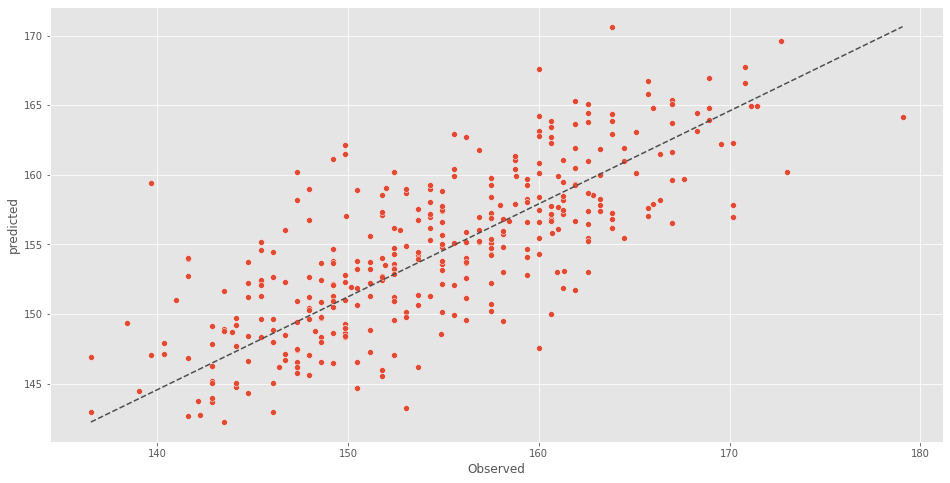

In [28]:
adult_lm.plot_predicted()

#### plot predicted against observed

The following simulation shows the amount of variation in our fitted line given different size of observed data. The smaller the sample size, the less weaker the likelihood and thus greater variability.

In [29]:
def sample_size_simulator(data_sample_size):
    sample_data = adults.sample(data_sample_size)
    sample_data_x = torch.FloatTensor(sample_data['weight'].values).reshape(-1, 1)
    sample_data_y = torch.FloatTensor(sample_data['height'].values)
    sample_lm = BayesianMCMCLinearModel(X=sample_data_x, y=sample_data_y, prior=adult_model_prior, warmup_steps=50, num_samples=100)
    sample_lm.fit()
    samples = sample_lm.generate_posterior_samples(1000)
    alpha_post_mean = samples['bias'].mean()
    beta_post_mean = samples['weights'].mean()
    sns.scatterplot(data=sample_data, x='weight', y='height')
    x = np.linspace(min(sample_data['weight']), max(sample_data['weight']))
    
    sample_index = np.random.choice(100, 20)
    for i in sample_index:
        sns.lineplot(x=x, y=samples['bias'][i] + samples['weights'][i] * x, color='blue')

Sample: 100%|██████████| 150/150 [00:43,  3.48it/s, step size=2.56e-02, acc. prob=0.982]


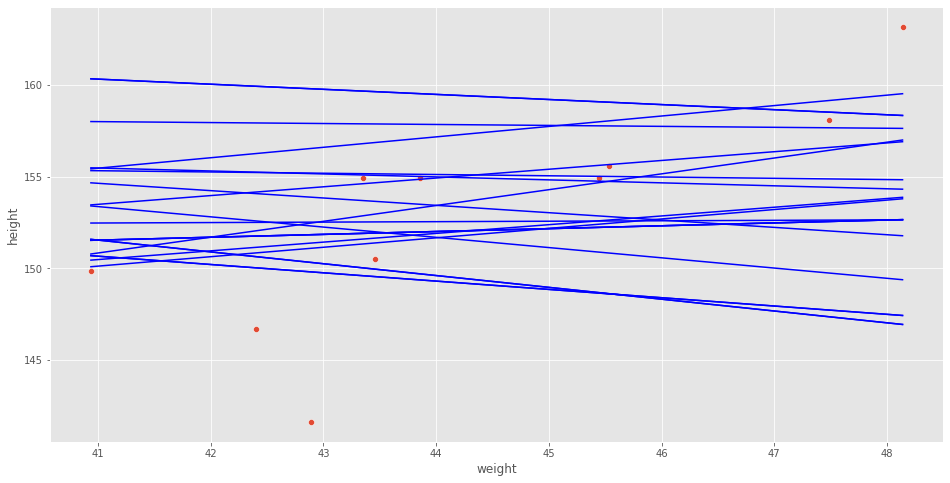

In [30]:
sample_size_simulator(10)

Sample: 100%|██████████| 150/150 [00:04, 31.20it/s, step size=1.36e-01, acc. prob=0.178]


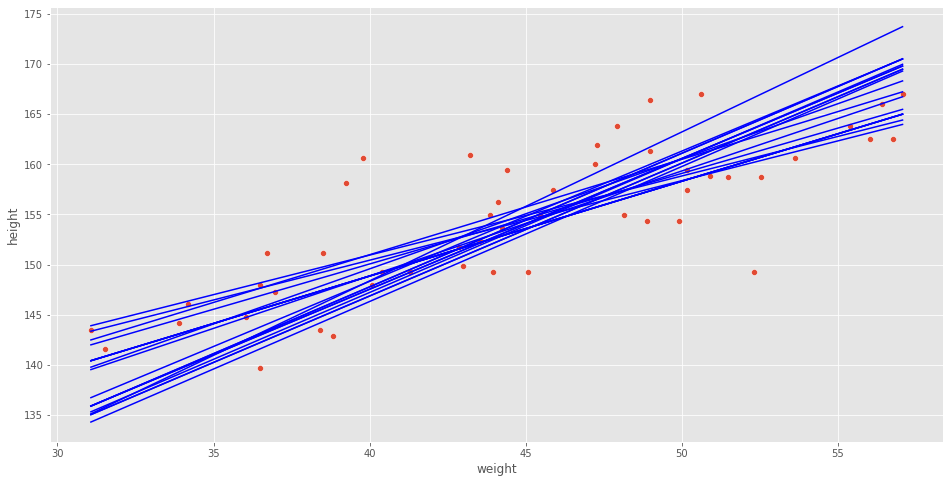

In [31]:
sample_size_simulator(50)

Sample: 100%|██████████| 150/150 [00:15,  9.79it/s, step size=3.71e-02, acc. prob=0.789]


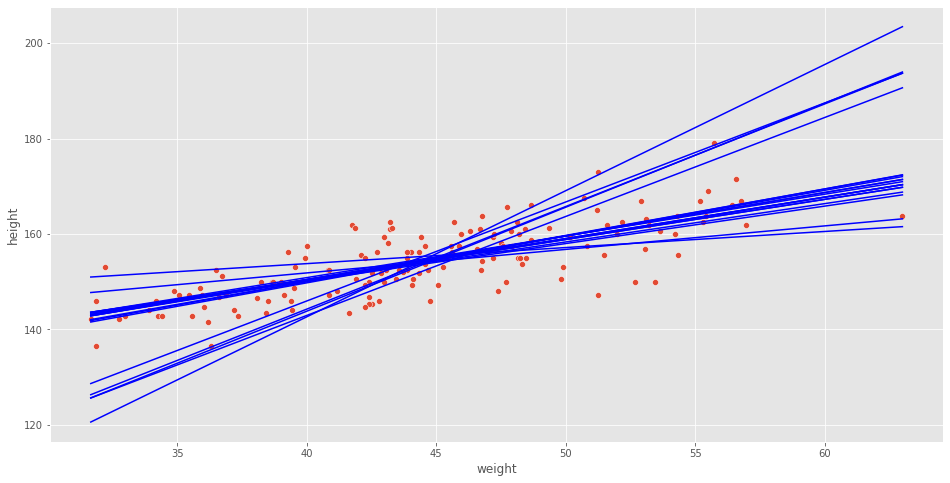

In [32]:
sample_size_simulator(150)

### Prediction interval for the mean $\mu$

The following shows the predicted mean and the variability of the mean. The mean is generated using the posterior mean and the variability comes from all the combinations of bias and weights sampled from the posterior distribution.

This is the variability of the model given the parameters.

In [33]:
posterior_sample = adult_lm.generate_posterior_samples(1000)

mu = torch.arange(25, 70, step=1)

bias_mean = posterior_sample['bias'].mean()
weights_mean = posterior_sample['weights'].mean()

In [34]:
upper_mu = []
lower_mu = []
for m in mu:
    hpdi = stats.hpdi(posterior_sample['bias'] + posterior_sample['weights'].matmul(m.reshape(-1, ).float()), 0.89)
    upper_mu.append(hpdi[1].item())
    lower_mu.append(hpdi[0].item())

<AxesSubplot:xlabel='weight', ylabel='height'>

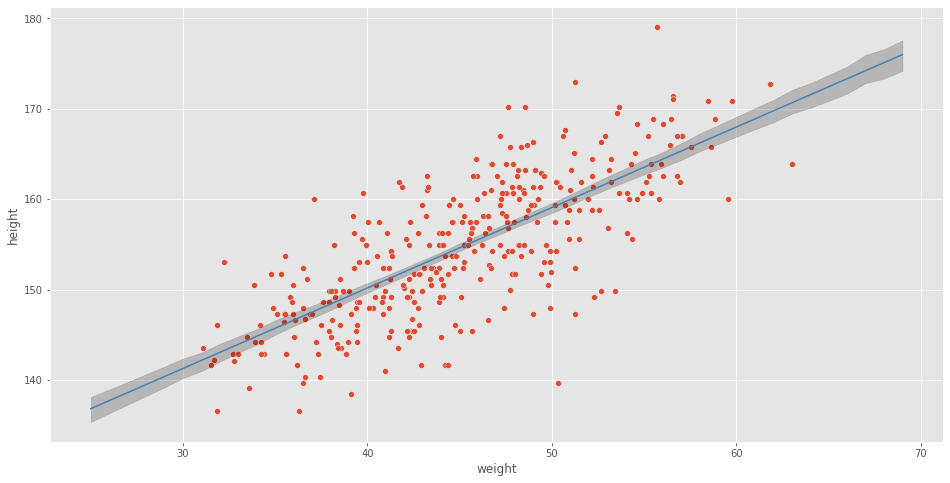

In [35]:
ax = sns.scatterplot(data=adults, x='weight', y='height')
ax.fill_between(mu, lower_mu, upper_mu, color='k', alpha=0.2)
sns.lineplot(x=mu, y=bias_mean + weights_mean * mu, color='steelblue')

### Prediction interval

Predictive prediction interval for the height, in addition to the variability around the mean, we now include the variability of the oberserved height $\sigma$.

The benefit of this is taht we can decompose the variability into parameter in the expected value or the sigma.

<AxesSubplot:xlabel='weight', ylabel='height'>

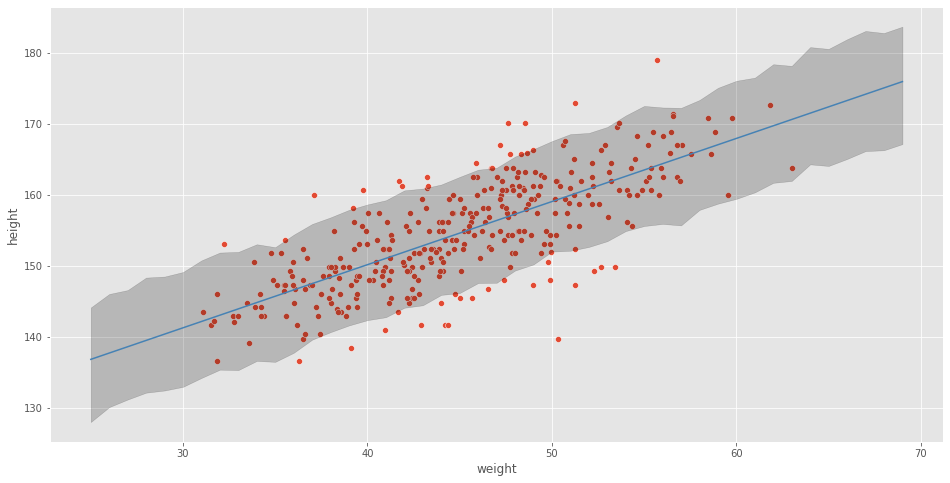

In [36]:
upper_mu = []
lower_mu = []
for m in mu:
    prior_predictive_mean = posterior_sample['bias'] + posterior_sample['weights'].matmul(m.reshape(1, ).float())
    posterior_predictive_mean = torch.tensor([dist.Normal(m, posterior_sample['sigma'][ind]).sample().item() for ind, m in enumerate(prior_predictive_mean)])
    hpdi = stats.hpdi(posterior_predictive_mean, prob=0.89)
    upper_mu.append(hpdi[1].item())
    lower_mu.append(hpdi[0].item())
    
ax = sns.scatterplot(data=adults, x='weight', y='height')
ax.fill_between(mu, lower_mu, upper_mu, color='k', alpha=0.2)
sns.lineplot(x=mu, y=bias_mean + weights_mean * mu, color='steelblue')